In [ ]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q scikit-image matplotlib numpy scipy pillow
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete. Use files.upload() to upload data, files.download() to download results.")
else:
    print("Running in local environment")

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_03/code_examples/example_01_image_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 03 Example 1: Image Filtering Techniques - Gaussian vs Median

This notebook compares different image filtering approaches for noise reduction in STEM-HAADF images.
We'll analyze how Gaussian and Median filters handle different types of noise and structural features.

## Overview

| Filter Type | Mechanism | Best For | Pros | Cons |
|---|---|---|---|---|
| **Gaussian** | Linear weighted average (convolution) | Gaussian/random noise (e.g., electronic noise) | Very smooth results | Blurs sharp edges |
| **Median** | Non-linear rank-order (replaces pixel with median of neighbors) | Salt & pepper/impulse noise | Preserves edges perfectly | Can remove fine details |

### Key Concepts:
- **Gaussian Filter**: Applies a bell-shaped kernel. Controlled by `sigma` (standard deviation).
- **Median Filter**: Replaces each pixel with the median value of its neighborhood.
- **Trade-off**: Noise reduction vs. detail preservation

## 1. Load and Inspect Data

### Available Datasets

This notebook supports multiple datasets for filter comparison:

1. **Au FCC (STEM-HAADF)**: High-resolution STEM image of Au nanoparticles
2. **GaAs (IDB-1)**: GaAs semiconductor specimen (EMD format)

To switch datasets, modify the `selected_dataset` variable in the code cell below.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from PIL import Image
import os

# Available datasets
available_datasets = {
    "Au FCC (STEM-HAADF)": "../assignments/raw_data/STEM-HAADF-Aufcc-Auhcp.tif",
    "GaAs (IDB-1)": "../assignments/raw_data/GaAs_IDB_1.emd"
}

# Select which dataset to use (change this to switch datasets)
selected_dataset = "Au FCC (STEM-HAADF)"  # Change to "GaAs (IDB-1)" to use the GaAs dataset

print(f"Available datasets:")
for name in available_datasets.keys():
    print(f"  - {name}")
print(f"\nSelected: {selected_dataset}\n")

data_path = available_datasets[selected_dataset]

# Check if file exists
if os.path.exists(data_path):
    # Handle different file formats
    if data_path.endswith('.emd'):
        # For EMD files, try to read with FabIO or a similar library
        try:
            import fabio
            emd_data = fabio.open(data_path)
            image = np.array(emd_data.data)
            print(f"EMD file loaded with fabio")
        except:
            print("FabIO not available. Trying alternative method...")
            # Alternative: try to load as a generic array
            try:
                from hyperspy.io import load
                s = load(data_path)
                image = s.data
                print(f"EMD file loaded with HyperSpy")
            except:
                print("Could not load EMD file. Install: pip install fabio hyperspy")
                image = None
    else:
        # For TIF/image files
        image = io.imread(data_path)
        print(f"Image file loaded with scikit-image")
    
    if image is not None:
        print(f"✓ Data loaded successfully!")
        print(f"  Shape: {image.shape}")
        print(f"  Data type: {image.dtype}")
        print(f"  Value range: [{image.min():.2f}, {image.max():.2f}]")
        print(f"  Mean: {image.mean():.2f}, Std: {image.std():.2f}")
else:
    print(f"✗ File not found at {data_path}")
    print("Available files in raw_data:")
    if os.path.exists("../assignments/raw_data"):
        print(os.listdir("../assignments/raw_data"))

Available datasets:
  - Au FCC (STEM-HAADF)
  - GaAs (IDB-1)

Selected: Au FCC (STEM-HAADF)

Image file loaded with scikit-image
✓ Data loaded successfully!
  Shape: (960, 2048)
  Data type: uint16
  Value range: [11532.00, 29761.00]
  Mean: 18484.70, Std: 4255.93


## 2. Visualize Original Image

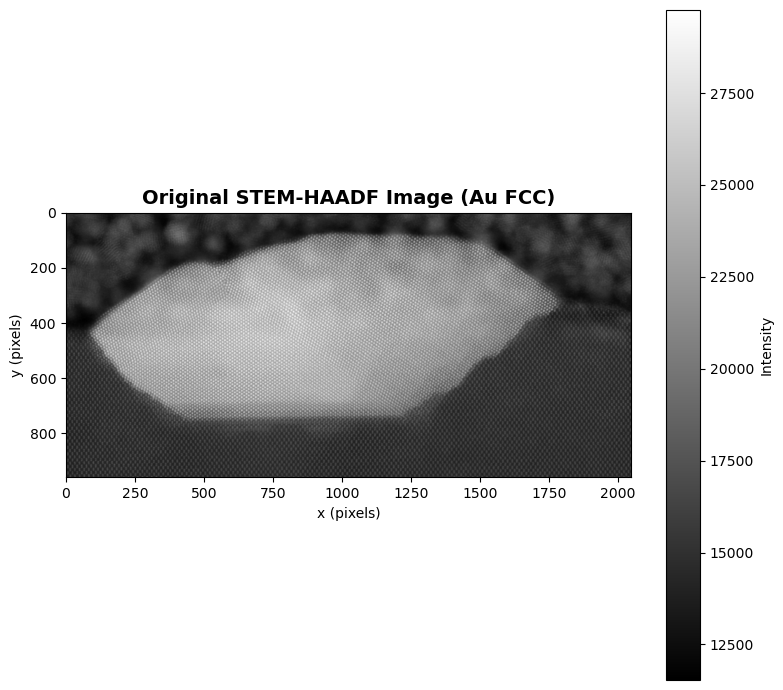

Image dimensions: (960, 2048)


In [9]:
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(image, cmap='gray')
ax.set_title('Original STEM-HAADF Image (Au FCC)', fontsize=14, fontweight='bold')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.colorbar(im, ax=ax, label='Intensity')
plt.tight_layout()
plt.show()

print(f"Image dimensions: {image.shape}")

## 3. Apply Gaussian Filter

Gaussian filter (sigma=0.5) applied
Gaussian filter (sigma=1.0) applied
Gaussian filter (sigma=1.5) applied


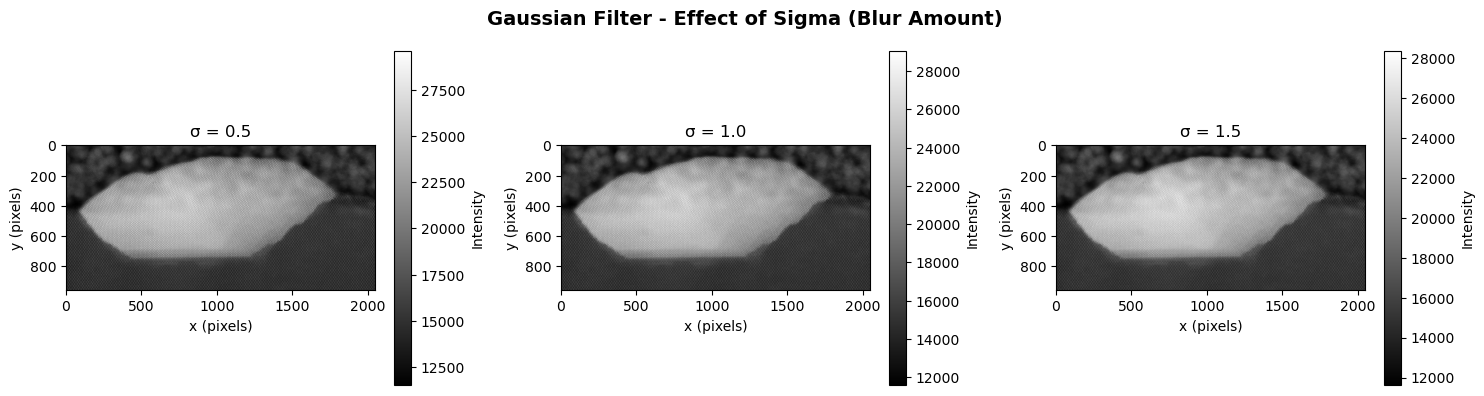


Gaussian Filter Mechanism:
- Linear weighted average using bell-shaped kernel
- Smooth results, but blurs sharp edges
- Best for Gaussian/random noise (electronic noise)


In [3]:
# Gaussian filtering with different sigma values
sigma_values = [0.5, 1.0, 1.5]

gaussian_filtered = {}
for sigma in sigma_values:
    gaussian_filtered[sigma] = filters.gaussian(image.astype(float), sigma=sigma)
    print(f"Gaussian filter (sigma={sigma}) applied")

# Visualize different sigma values
fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 4))
fig.suptitle('Gaussian Filter - Effect of Sigma (Blur Amount)', fontsize=14, fontweight='bold')

for i, sigma in enumerate(sigma_values):
    im = axes[i].imshow(gaussian_filtered[sigma], cmap='gray')
    axes[i].set_title(f'σ = {sigma}', fontsize=12)
    axes[i].set_xlabel('x (pixels)')
    axes[i].set_ylabel('y (pixels)')
    plt.colorbar(im, ax=axes[i], label='Intensity')

plt.tight_layout()
plt.show()

print("\nGaussian Filter Mechanism:")
print("- Linear weighted average using bell-shaped kernel")
print("- Smooth results, but blurs sharp edges")
print("- Best for Gaussian/random noise (electronic noise)")

## 4. Apply Median Filter

Median filter (footprint=3x3) applied
Median filter (footprint=5x5) applied
Median filter (footprint=7x7) applied


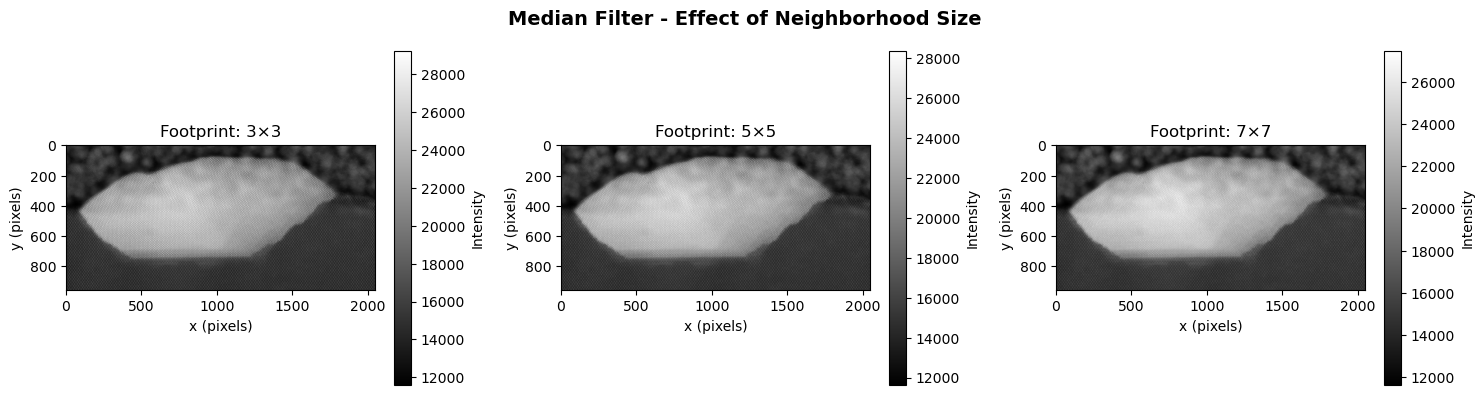


Median Filter Mechanism:
- Non-linear rank-order operation
- Replaces pixel with median of neighborhood
- Preserves edges perfectly but can remove fine details
- Best for salt & pepper/impulse noise


In [4]:
from scipy import ndimage

# Median filtering with different footprint sizes
footprint_sizes = [3, 5, 7]

median_filtered = {}
for size in footprint_sizes:
    # Create a square footprint (neighborhood)
    footprint = np.ones((size, size))
    median_filtered[size] = ndimage.median_filter(image.astype(float), footprint=footprint)
    print(f"Median filter (footprint={size}x{size}) applied")

# Visualize different footprint sizes
fig, axes = plt.subplots(1, len(footprint_sizes), figsize=(15, 4))
fig.suptitle('Median Filter - Effect of Neighborhood Size', fontsize=14, fontweight='bold')

for i, size in enumerate(footprint_sizes):
    im = axes[i].imshow(median_filtered[size], cmap='gray')
    axes[i].set_title(f'Footprint: {size}×{size}', fontsize=12)
    axes[i].set_xlabel('x (pixels)')
    axes[i].set_ylabel('y (pixels)')
    plt.colorbar(im, ax=axes[i], label='Intensity')

plt.tight_layout()
plt.show()

print("\nMedian Filter Mechanism:")
print("- Non-linear rank-order operation")
print("- Replaces pixel with median of neighborhood")
print("- Preserves edges perfectly but can remove fine details")
print("- Best for salt & pepper/impulse noise")

## 5. Direct Comparison: Gaussian vs Median

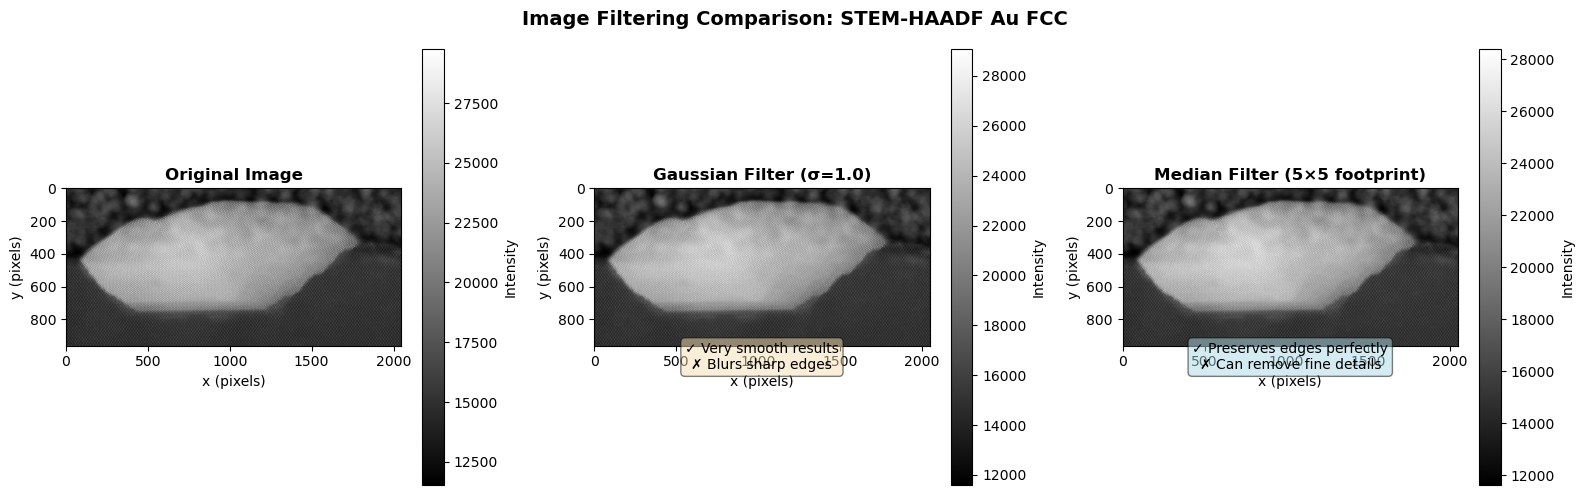

In [5]:
# Use moderate filter parameters for comparison
gaussian_result = filters.gaussian(image.astype(float), sigma=1.0)
median_result = ndimage.median_filter(image.astype(float), footprint=np.ones((5, 5)))

# Create comparison plot (similar to slide format)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Image Filtering Comparison: STEM-HAADF Au FCC', fontsize=14, fontweight='bold')

# Original
im0 = axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x (pixels)')
axes[0].set_ylabel('y (pixels)')
plt.colorbar(im0, ax=axes[0], label='Intensity')

# Gaussian
im1 = axes[1].imshow(gaussian_result, cmap='gray')
axes[1].set_title('Gaussian Filter (σ=1.0)', fontsize=12, fontweight='bold')
axes[1].text(0.5, -0.15, '✓ Very smooth results\n✗ Blurs sharp edges', 
             transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].set_xlabel('x (pixels)')
axes[1].set_ylabel('y (pixels)')
plt.colorbar(im1, ax=axes[1], label='Intensity')

# Median
im2 = axes[2].imshow(median_result, cmap='gray')
axes[2].set_title('Median Filter (5×5 footprint)', fontsize=12, fontweight='bold')
axes[2].text(0.5, -0.15, '✓ Preserves edges perfectly\n✗ Can remove fine details', 
             transform=axes[2].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[2].set_xlabel('x (pixels)')
axes[2].set_ylabel('y (pixels)')
plt.colorbar(im2, ax=axes[2], label='Intensity')

plt.tight_layout()
plt.show()

## 6. Quantitative Comparison

QUANTITATIVE COMPARISON

Gaussian Filter (σ=1.0):
  Mean absolute difference: 161.0581
  Max absolute difference: 1359.3923
  Std of differences: 160.2081

Median Filter (5×5):
  Mean absolute difference: 273.0092
  Max absolute difference: 2683.0000
  Std of differences: 312.9115

Difference visualization:


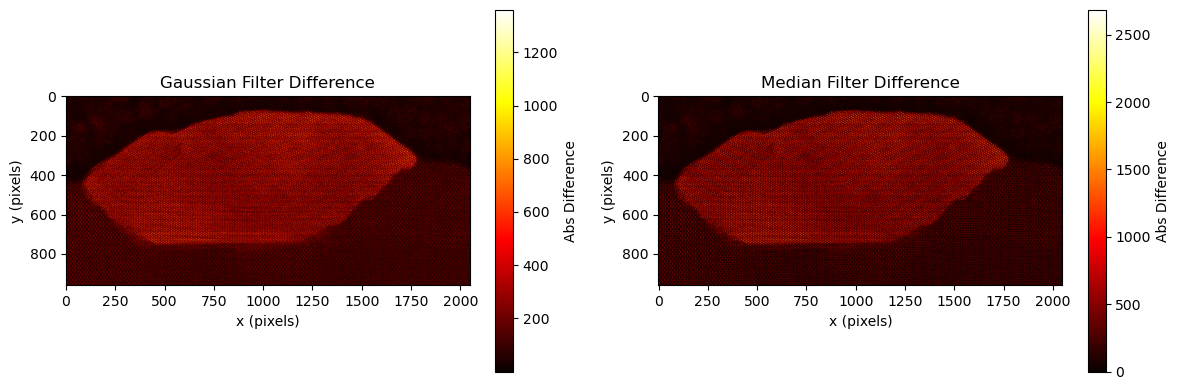

In [6]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Calculate differences from original
diff_gaussian = np.abs(gaussian_result - image.astype(float))
diff_median = np.abs(median_result - image.astype(float))

# Metrics
print("=" * 60)
print("QUANTITATIVE COMPARISON")
print("=" * 60)
print(f"\nGaussian Filter (σ=1.0):")
print(f"  Mean absolute difference: {diff_gaussian.mean():.4f}")
print(f"  Max absolute difference: {diff_gaussian.max():.4f}")
print(f"  Std of differences: {diff_gaussian.std():.4f}")

print(f"\nMedian Filter (5×5):")
print(f"  Mean absolute difference: {diff_median.mean():.4f}")
print(f"  Max absolute difference: {diff_median.max():.4f}")
print(f"  Std of differences: {diff_median.std():.4f}")

print(f"\nDifference visualization:")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(diff_gaussian, cmap='hot')
axes[0].set_title('Gaussian Filter Difference', fontsize=12)
axes[0].set_xlabel('x (pixels)')
axes[0].set_ylabel('y (pixels)')
plt.colorbar(im0, ax=axes[0], label='Abs Difference')

im1 = axes[1].imshow(diff_median, cmap='hot')
axes[1].set_title('Median Filter Difference', fontsize=12)
axes[1].set_xlabel('x (pixels)')
axes[1].set_ylabel('y (pixels)')
plt.colorbar(im1, ax=axes[1], label='Abs Difference')

plt.tight_layout()
plt.show()

## 7. Edge Preservation Analysis

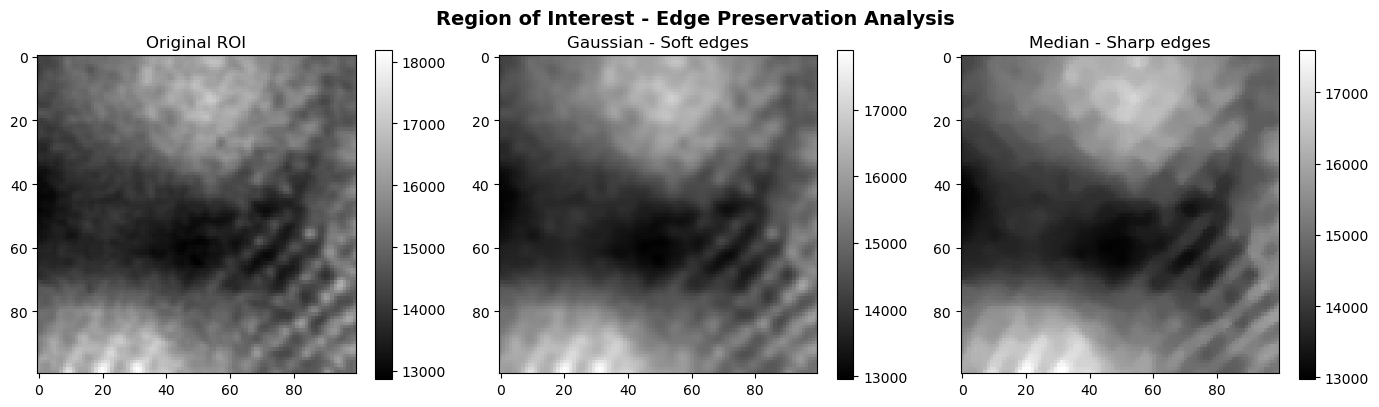

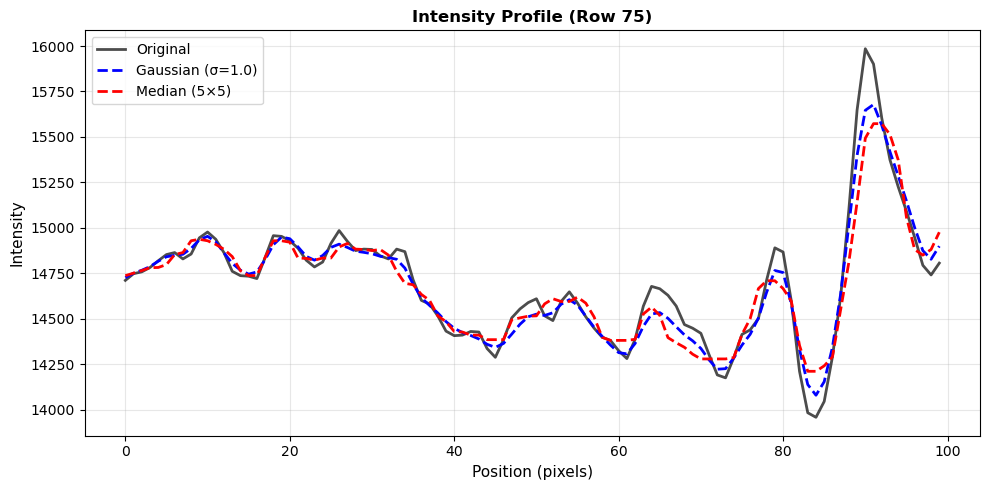


Edge Preservation Observations:
- Gaussian filter smooths transitions (gradual edge transition)
- Median filter preserves sharp intensity transitions (abrupt edge)
- Choice depends on whether you want to preserve or enhance edges


In [7]:
# Extract a region of interest to visualize edge preservation
# Select a region with interesting features
roi_y = slice(50, 150)
roi_x = slice(50, 150)

roi_original = image[roi_y, roi_x]
roi_gaussian = gaussian_result[roi_y, roi_x]
roi_median = median_result[roi_y, roi_x]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Region of Interest - Edge Preservation Analysis', fontsize=14, fontweight='bold')

im0 = axes[0].imshow(roi_original, cmap='gray')
axes[0].set_title('Original ROI')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(roi_gaussian, cmap='gray')
axes[1].set_title('Gaussian - Soft edges')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(roi_median, cmap='gray')
axes[2].set_title('Median - Sharp edges')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Plot intensity profile across a line
profile_line = 75
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(roi_original[profile_line, :], 'k-', label='Original', linewidth=2, alpha=0.7)
ax.plot(roi_gaussian[profile_line, :], 'b--', label='Gaussian (σ=1.0)', linewidth=2)
ax.plot(roi_median[profile_line, :], 'r--', label='Median (5×5)', linewidth=2)

ax.set_xlabel('Position (pixels)', fontsize=11)
ax.set_ylabel('Intensity', fontsize=11)
ax.set_title(f'Intensity Profile (Row {profile_line})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEdge Preservation Observations:")
print("- Gaussian filter smooths transitions (gradual edge transition)")
print("- Median filter preserves sharp intensity transitions (abrupt edge)")
print("- Choice depends on whether you want to preserve or enhance edges")

## 8. Key Takeaways

### When to Use Each Filter:

**Gaussian Filter:**
- ✓ Best for Gaussian/random noise (e.g., electronic noise in detectors)
- ✓ Produces very smooth results
- ✓ Mathematically elegant and fast
- ✗ Blurs sharp edges and fine structural details
- ✗ Not ideal for salt & pepper noise

**Median Filter:**
- ✓ Best for salt & pepper/impulse noise
- ✓ Preserves edges perfectly
- ✓ Non-linear - more sophisticated noise handling
- ✗ Can remove fine details if footprint is too large
- ✗ Computationally more expensive

### General Recommendations:
1. **For STEM-HAADF images**: Often use Gaussian for smooth detector noise, but consider Median for outlier events
2. **Parameter Selection**: 
   - Gaussian: start with σ = 0.5-1.0 pixels
   - Median: start with 3×3 or 5×5 footprint
3. **Visual Inspection**: Always compare filtered results to original to avoid over-filtering
4. **Downstream Impact**: Consider what analysis follows (e.g., peak detection, structural analysis)